In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import pickle

## Analyzing dataset 

In [ ]:
df=pd.read_csv("US_Accidents_March23.csv")
df.describe()

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
#plotting the covariance matrix as a heat map

corr_matrix=df.corr(numeric_only=True)
plt.figure(figsize=(14, 12))  # Adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

In [ ]:
#dropping highly correlated features

featuresToRemove = ['Bump','Crossing','End_Lat','End_Lng','Wind_Chill(F)']
df.drop(columns=featuresToRemove,inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
heatmap_data = pd.crosstab(df['Give_Way'], df['Severity'])
heatmap_data= heatmap_data.div(heatmap_data.sum(axis=1), axis=0)
plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")  

In [ ]:
#trying to find if wind_speed significantly contribute to severity
# I tested with many other features to try to find out if there is any significant contribution of these feature to the model

sns.boxplot(x='Severity', y='WindSpeed(mi)', data=df)

In [ ]:
#some features values are missing and they contribute less to whole interpretation so better to remove that particular rows them also


featToRemove = ['Precipitation(in)','Wind_Speed(mph)','Nautical_Twilight','Astronomical_Twilight',
              'Give_Way','Amenity','Pressure(in)','Humidity(%)',
                'Weather_Timestamp','Country','Zipcode']

df.drop(columns=featToRemove,inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

In [ ]:
featureToRemove=['Description','Airport_Code','Station','Railway','Station','Wind_Direction','Timezone','ID','Start_Time','End_Time','Source','Street','County']
df.drop(columns=featureToRemove,inplace=True)

In [ ]:
df.head()

In [ ]:
df.nunique()

## Model Training and Preprocessing


In [1]:
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
# this was used to just intialize with the edited data after the data cleaning is done
df = pd.read_csv('Edited_US_accidents.csv')

In [6]:
# Splitting Label and Feature

y=df['Severity']
X=df.drop(columns=['Severity'])

del df

### Preprocessing

In [7]:
# Splitting Numerical and Categorical Features

X_num=['Start_Lat','Start_Lng','Distance(mi)','Temperature(F)','Visibility(mi)']
X_cat=['City','State','Weather_Condition','Junction','No_Exit','Roundabout','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight']

In [8]:
# Preprocessing

encoder = OrdinalEncoder()
X[X_cat] = encoder.fit_transform(X[X_cat])

encoder = StandardScaler()
X[X_num + ['City','Weather_Condition']] = encoder.fit_transform(X[X_num + ['City','Weather_Condition']])

### Spliting The Dataset

In [9]:
# Using Stratified Folding to minimize class imbalance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

del X,y

### Model Training and Accuracy

In [ ]:
# Model Training

## I have tried other two ensemble learning xgboost and light gradient machine apart from this but both were having similiar performance to Random Forest so I just skipped them in this code

clf = RandomForestClassifier(n_estimators=50,n_jobs= -1 )
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1)

In [11]:
pickle_in = open('clf_100trees.pickle','rb')
clf=pickle.load(pickle_in)

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [ ]:
# accuracy , precision, recall

#accuracy
print(clf.score(X_test,y_test))



NameError: name 'clf' is not defined

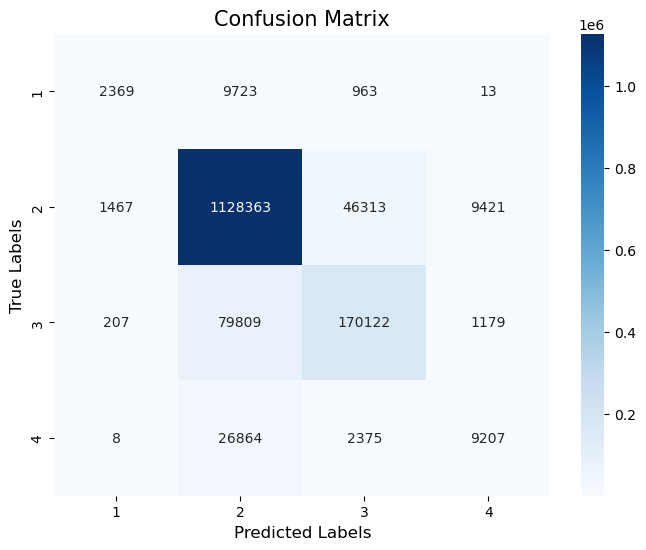

In [ ]:
# Confusion Matrix

y_pred = clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred,labels=[1,2,3,4])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4'])

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [ ]:
# Compute AUC for each class (One-vs-Rest)
y_pred_prob = clf.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3, 4])


roc_auc_per_class = {}
for i in range(4):  # Number of classes
    roc_auc_per_class[i] = roc_auc_score(y_test_binarized[:, i], y_pred_prob[:, i])

print("AUC for each class:", roc_auc_per_class)


AUC for each class: {0: 0.8446071749649333, 1: 0.9073776950356117, 2: 0.939165043962612, 3: 0.8736605812218721}


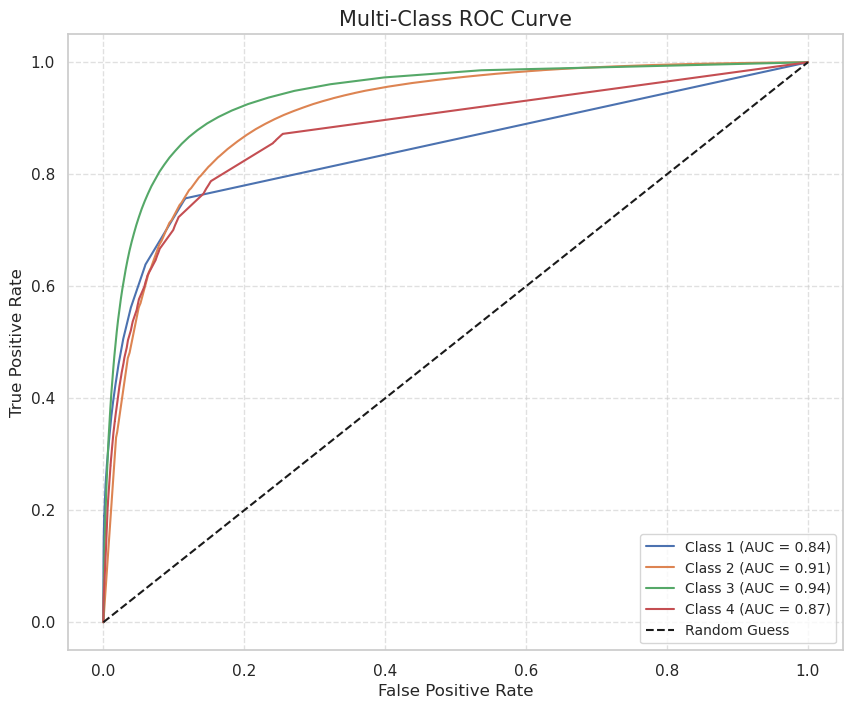

In [ ]:
# Plotting the ROC AUC curve

fpr = {}
tpr = {}
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

for i in range(y_test_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc_per_class[i]:.2f})')

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.6, linestyle='--')
plt.show()
